In [1]:
import VolGANSwaps as VGS
import Inputs
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import numpy.random as rnd
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import scipy as sp
from scipy.stats import norm
import pandas_datareader as pd_data
from pandas_datareader import data as pdr
import yfinance as yf
from datetime import datetime
from statsmodels.tsa.stattools import acf, pacf
from scipy.interpolate import interp1d
from numpy import arange, array, exp

In [2]:
SURFACE_PATH = "data/swaption_atm_vol_full_NEW.xlsx"
DATA_PATH = "data/forward_sofr_swap_full_NEW.xlsx"

surfaces_transform, returns, tenor, tau, tenors, taus, dates_dt = VGS.SwapsData(DATA_PATH, SURFACE_PATH)
true, condition, m_in,sigma_in, m_out, sigma_out, dates_t,  tenor, tau, tenors, taus = VGS.DataPreprocesssing(DATA_PATH, SURFACE_PATH)

In [3]:
tr = 0.85
noise_dim = 32
hidden_dim = 16
device = 'cpu'
n_epochs = 10000
n_grad = 250
val = True
vol_model = 'normal'
lrg = 0.0001 
lrd = 0.0001 
batch_size = 100 
device = 'cpu'

true_train, true_test, condition_train, condition_test,  m_in,sigma_in, m_out, sigma_out, dates_t,  tenor, tau, tenors, taus = VGS.DataTrainTest(DATA_PATH, SURFACE_PATH, tr, vol_model, device)
gen = VGS.Generator(noise_dim=noise_dim,cond_dim=condition_train.shape[2], hidden_dim=hidden_dim,output_dim=true_train.shape[2],mean_in = m_in, std_in = sigma_in, mean_out = m_out, std_out = sigma_out)
gen.to(device)

# m_disc and sigma_disc are not used in the original VolGAN, you can see in the Discriminator forward function 
# we'll preserve the forward pass for now but we can maybe incorporate these later if needed    
m_disc = torch.cat((m_in,m_out),dim=-1)
sigma_disc = torch.cat((sigma_in,sigma_out),dim=-1)

disc = VGS.Discriminator(in_dim = condition_train.shape[2] + true_train.shape[2], hidden_dim = hidden_dim, mean = m_disc, std = sigma_disc)
disc.to(device)

true_val = False
condition_val = False

gen_opt = torch.optim.RMSprop(gen.parameters(), lr=lrg)
disc_opt = torch.optim.RMSprop(disc.parameters(), lr=lrd)

criterion = nn.BCELoss()
criterion = criterion.to(device)

In [4]:
# run this to load the model without training again
gen.load_state_dict(torch.load('model/generator_parameters_full.pth'))
disc.load_state_dict(torch.load('model/discriminator_parameters_full.pth'))

<All keys matched successfully>

In [5]:
df_raw = pd.read_excel(SURFACE_PATH, header=None)
multi_index = pd.MultiIndex.from_arrays([df_raw.iloc[0], df_raw.iloc[1], df_raw.iloc[2]])
multi_index.names = multi_index[0]
multi_index = multi_index[1:]

In [6]:
from pen_torch import arbitrage_penalty_batch
yield_curve = pd.read_excel("data/usd_sofr_curve_full.xlsx")
forward_swap_df = pd.read_excel("data/forward_sofr_swap_full_NEW.xlsx")
tm_df = pd.read_excel("data/forward_sofr_swap_full_NEW.xlsx") 

In [7]:
def get_all_ns_inputs_from_df(yield_curve_df):
    df = yield_curve_df.set_index("TENOR")
    outputs = {}
    for date, row in df.iloc[1:].iterrows():
        times = []
        rates = []
        for col in row.index:
            val = col[:-1]
            unit = col[-1]
            if unit == "M":
                t = float(val) / 12
            else:
                t = float(val)
            times.append(t)
            rates.append(row[col] / 100)
        times_t = torch.tensor(times, dtype=torch.float)
        rates_t = torch.tensor(rates, dtype=torch.float)
        outputs[date] = (times_t, rates_t)
    return outputs

yields = get_all_ns_inputs_from_df(yield_curve)

In [8]:
import pandas as pd
import torch
from tqdm import tqdm
from pen_torch import ns_fit, option_price_batch, arbitrage_penalty_batch

In [100]:
forward_swap_df

,MATRUITY (EXPIRY),1M,1M.1,1M.2,1M.3,1M.4,1M.5,1M.6,1M.7,1M.8,...,25Y.8,30Y,30Y.1,30Y.2,30Y.3,30Y.4,30Y.5,30Y.6,30Y.7,30Y.8
0,TERM (TENOR),1Y,2Y,3Y,4Y,5Y,6Y,7Y,8Y,9Y,...,9Y,1Y,2Y,3Y,4Y,5Y,6Y,7Y,8Y,9Y
1,Ticker,S0042FS 1Y1M BLC Curncy,S0042FS 2Y1M BLC Curncy,S0042FS 3Y1M BLC Curncy,S0042FS 4Y1M BLC Curncy,S0042FS 5Y1M BLC Curncy,S0042FS 6Y1M BLC Curncy,S0042FS 7Y1M BLC Curncy,S0042FS 8Y1M BLC Curncy,S0042FS 9Y1M BLC Curncy,...,S0042FS 9Y25Y BLC Curncy,S0042FS 1Y30Y BLC Curncy,S0042FS 2Y30Y BLC Curncy,S0042FS 3Y30Y BLC Curncy,S0042FS 4Y30Y BLC Curncy,S0042FS 5Y30Y BLC Curncy,S0042FS 6Y30Y BLC Curncy,S0042FS 7Y30Y BLC Curncy,S0042FS 8Y30Y BLC Curncy,S0042FS 9Y30Y BLC Curncy
2,2025-01-10 00:00:00,4.0661,4.1379,4.1364,4.1339,4.1491,4.1527,4.1593,4.1726,4.1962,...,3.7727,4.0118,3.9763,3.9358,3.8934,3.8497,3.8027,3.7535,3.7021,3.6474
3,2025-01-09 00:00:00,3.9148,3.9922,4.0277,4.0657,4.1016,4.1192,4.1407,4.1716,4.2065,...,3.8087,4.0041,3.978,3.9465,3.9107,3.8715,3.8282,3.7818,3.732,3.6784
4,2025-01-08 00:00:00,3.9364,4.0082,4.0314,4.0687,4.097,4.1133,4.1532,4.1709,4.2166,...,3.8179,4.0115,3.9849,3.953,3.918,3.8789,3.8364,3.7908,3.7413,3.6885
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
839,2021-09-24 00:00:00,0.3139,0.9332,1.2707,1.4443,1.6065,1.6173,1.7063,1.719,1.719,...,1.595,1.5486,1.5854,1.601,1.6032,1.5983,1.5861,1.5737,1.5567,1.5393
840,2021-09-23 00:00:00,0.2978,0.962,1.2661,1.4464,1.5666,1.5745,1.6597,1.6659,1.6658,...,1.5428,1.5058,1.541,1.5541,1.5537,1.5468,1.5346,1.5221,1.5055,1.4887
841,2021-09-22 00:00:00,0.2689,0.8582,1.1376,1.2876,1.3989,1.4134,1.4921,1.4977,1.4977,...,1.4118,1.3728,1.4038,1.4154,1.4157,1.4099,1.3993,1.3883,1.3736,1.3587
842,2021-09-21 00:00:00,0.2339,0.8074,1.118,1.296,1.4582,1.4691,1.5664,1.5733,1.5733,...,1.4679,1.4169,1.4523,1.4683,1.4715,1.4675,1.4566,1.4454,1.4297,1.4137


In [99]:
### TESTING REWORK OF THE FUNCTION

# Assume true_test is a DataFrame indexed by date; use its index as our test dates.
n_test = true_test.shape[0]
test_dates = dates_t[-n_test:]
n_test = len(test_dates)

# Define the grid shape as 16x9 (16 expiry values x 9 tenor values = 144 spots)
grid_shape = (16, 9)

def convert_label(s):
    s = str(s)
    if 'M' in s and 'Y' not in s:
        return float(s.replace('M',''))/12
    elif 'Y' in s:
        return float(s.replace('Y',''))
    else:
        return float(s)

cols = forward_swap_df.columns[1:]
# Build day-specific market grid parameters (assume forward_swap_df and tm_df are indexed by date)
forward_swap_list = []
tm_tenor_list = []
tm_maturity_list = []
for date in test_dates:
    # Extract the forward swap values for this date (assumed shape: (144,))
    row_fwd = forward_swap_df.loc[date, cols].astype(float).values  
    fwd_tensor = torch.tensor(row_fwd, dtype=torch.float).view(*grid_shape)  # (16,9)
    forward_swap_list.append(fwd_tensor)
    
    # Extract tenor values (from forward_swap_df row with labels); if tenor is fixed over time, you might use a single row.
    row_tenor = forward_swap_df.loc[date, cols].apply(convert_label).values  
    tenor_tensor = torch.tensor(row_tenor, dtype=torch.float).view(*grid_shape)  # (16,9)
    tm_tenor_list.append(tenor_tensor)
    
    # Extract maturity values from tm_df for this date.
    row_tm = tm_df.loc[date, cols].astype(float).values  
    tm_tensor = torch.tensor(row_tm, dtype=torch.float).view(*grid_shape)  # (16,9)
    tm_maturity_list.append(tm_tensor)

# Stack the day-specific grids into tensors of shape [n_test, 16, 9]
forward_swap_stack = torch.stack(forward_swap_list, dim=0)
tm_tenor_stack = torch.stack(tm_tenor_list, dim=0)
tm_maturity_stack = torch.stack(tm_maturity_list, dim=0)

# Flatten the grids to obtain [n_test, 144] vectors
forward_flat = forward_swap_stack.view(n_test, -1)    # [n_test,144]
tenor_flat   = tm_tenor_stack.view(n_test, -1)          # [n_test,144]
maturity_flat = tm_maturity_stack.view(n_test, -1)       # [n_test,144]
strike_flat = forward_flat.clone()                     # [n_test,144]

# Process yield curve day-specific: assume yield_curve is indexed by date.
# get_all_ns_inputs_from_df should return a dict keyed by date.
yields = get_all_ns_inputs_from_df(yield_curve)
ns_params_list = []
for date in test_dates:
    yield_times, yield_rates = yields[date]
    ns_param = ns_fit(yield_times, yield_rates, lr=1e-2, n_iter=500)
    ns_params_list.append(ns_param)
# Stack NS parameters: shape [n_test, 4]
ns_params_stack = torch.stack(ns_params_list, dim=0)

# Generator and option pricing parameters:
underlying_dim = true_test.shape[1]
B = 10000  # number of models

time_series_prices = []
all_arb_penalties = []
time_series_surfaces = []
with torch.no_grad():
    for _ in tqdm(range(B)):
        noise = torch.randn((n_test, underlying_dim, noise_dim), device=device, dtype=torch.float)
        fake = gen(noise, condition_test)  # assume output shape: [n_test, feature_dim]
        surface_past_test = condition_test[:, :, 3:]
        fake_surface = fake[:, :, 1:] + surface_past_test
        # fake_surface expected shape: [n_test, X, 1]; adjust X to be 144 by padding/trimming along dim=1.
        vol_batch = fake_surface / 100.0  # current shape: [n_test, X, 1]
        vol_batch = vol_batch.squeeze(-1)   # now shape: [n_test, X]
        if vol_batch.shape[1] < 144:
            pad_size = 144 - vol_batch.shape[1]
            vol_batch = torch.nn.functional.pad(vol_batch, (0, pad_size), mode='constant', value=0)
        elif vol_batch.shape[1] > 144:
            vol_batch = vol_batch[:, :144]
        # Now vol_batch is [n_test,144]
        
        # For each date, price using its own market grid and NS parameters.
        prices_list = []
        for i in range(n_test):
            price_i = option_price_batch(
                forward_flat[i].unsqueeze(0), 
                strike_flat[i].unsqueeze(0), 
                vol_batch[i].unsqueeze(0),
                maturity_flat[i].unsqueeze(0), 
                tenor_flat[i].unsqueeze(0),
                ns_params_stack[i],  # day-specific NS parameters (shape: [4])
                delta=0.25
            )
            prices_list.append(price_i.squeeze(0))
        prices_batch = torch.stack(prices_list, dim=0)  # [n_test,144]
        # Reshape to grid: [n_test, 16, 9]
        prices_grid = prices_batch.view(n_test, *grid_shape)
        penalties = arbitrage_penalty_batch(prices_grid)
        time_series_prices.append(prices_grid)
        all_arb_penalties.append(penalties)
        time_series_surfaces.append(fake_surface.view(n_test, *grid_shape))
arb_penalties_tensor = torch.stack(all_arb_penalties, dim=0)
time_series_prices_tensor = torch.cat(time_series_prices, dim=0)
time_series_surfaces_tensor = torch.cat(time_series_surfaces, dim=0)


KeyError: Timestamp('2024-07-24 00:00:00')

In [40]:
# Define the grid shape as 16x9 (16 expiry values x 9 tenor values = 144 spots)
grid_shape = (16, 9)

def convert_label(s):
    s = str(s)
    if 'M' in s and 'Y' not in s:
        return float(s.replace('M',''))/12
    elif 'Y' in s:
        return float(s.replace('Y',''))
    else:
        return float(s)

cols = forward_swap_df.columns[1:]
forward_swap_tensor = torch.tensor(forward_swap_df.iloc[2][cols].astype(float).values, dtype=torch.float)
forward_swap_tensor = forward_swap_tensor.view(*grid_shape)  # shape: (16, 9)
tm_tenor = torch.tensor(forward_swap_df.iloc[0][cols].apply(convert_label).values, dtype=torch.float)
tm_tenor = tm_tenor.view(*grid_shape)
tm_maturity = torch.tensor(tm_df.iloc[2][cols].astype(float).values, dtype=torch.float)
tm_maturity = tm_maturity.view(*grid_shape)

# Flatten the grid data to obtain 144-element vectors
forward_flat = forward_swap_tensor.view(-1)   # shape: (144,)
tenor_flat = tm_tenor.view(-1)                 # shape: (144,)
maturity_flat = tm_maturity.view(-1)           # shape: (144,)
strike_flat = forward_flat.clone()             # shape: (144,)

yields = get_all_ns_inputs_from_df(yield_curve)
some_date = list(yields.keys())[0]
yield_times, yield_rates = yields[some_date]
ns_params = ns_fit(yield_times, yield_rates, lr=1e-2, n_iter=500)

n_test = true_test.shape[0]   # e.g. 116 dates
underlying_dim = true_test.shape[1]
B = 10000

time_series_prices = []
all_arb_penalties = []
time_series_surfaces = []
with torch.no_grad():
    for _ in range(B):
        noise = torch.randn((n_test, underlying_dim, noise_dim), device=device, dtype=torch.float)
        fake = gen(noise, condition_test)  # assume output shape: [n_test, feature_dim]
        surface_past_test = condition_test[:, :, 3:]
        fake_surface = fake[:, :, 1:] + surface_past_test
        # fake_surface now has shape [n_test, X, 1] where X is expected to be 144, but here it's 114.
        # We need vol_batch to have 144 columns. So, adjust by padding/trimming along dim=1.
        vol_batch = fake_surface / 100.0  # current shape: [n_test, X, 1]
        vol_batch = vol_batch.squeeze(-1)   # now shape: [n_test, X]
        n_instruments = forward_flat.shape[0]  # 144
        forward_batch = forward_flat.unsqueeze(0).expand(n_test, n_instruments)
        strike_batch = strike_flat.unsqueeze(0).expand(n_test, n_instruments)
        maturity_batch = maturity_flat.unsqueeze(0).expand(n_test, n_instruments)
        tenor_batch = tenor_flat.unsqueeze(0).expand(n_test, n_instruments)
        prices_batch = option_price_batch(forward_batch, strike_batch, vol_batch,
                                          maturity_batch, tenor_batch, ns_params, delta=0.25)
        # Reshape the flat price vector into the 16x9 grid: [n_test, 16, 9]
        prices_grid = prices_batch.view(n_test, *grid_shape)
        penalties = arbitrage_penalty_batch(prices_grid)
        time_series_prices.append(prices_grid)
        all_arb_penalties.append(penalties)
        time_series_surfaces.append(fake_surface.view(n_test, *grid_shape))
arb_penalties_tensor = torch.stack(all_arb_penalties, dim=0)
time_series_prices_tensor = torch.cat(time_series_prices, dim=0)
time_series_surfaces_tensor = torch.cat(time_series_surfaces, dim=0)


In [49]:
len(arb_penalties_tensor)

10000

100%|██████████| 116/116 [00:00<00:00, 574.74it/s]


Mean mean before  0.44534892  and after reweighting  0.4429008377523258
std of means before  0.048354797  and after reweighting across time  0.049437929732126164
Mean median before  0.46742168  and median of means 0.4655658006668091


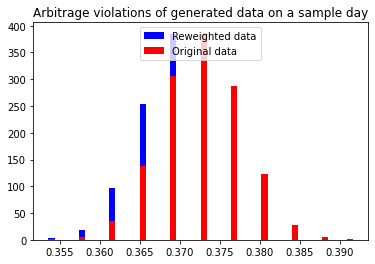

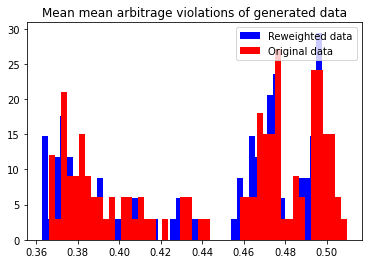

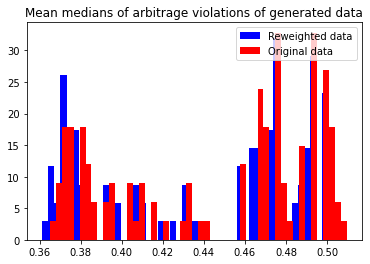

(116, 10000)

In [50]:
arb_penalties_np = arb_penalties_tensor.cpu().numpy().T
df_arb = pd.DataFrame(arb_penalties_np, index=dates_t[-n_test:], columns=[str(i) for i in range(arb_penalties_np.shape[1])])

from reweighting import reweighting_stats
stats = reweighting_stats(df_arb.to_numpy(), 100)

stats[1].shape

In [52]:
weights = torch.tensor(stats[1], device=device, dtype=torch.float)  # shape: [n_test, B]

surfaces = time_series_surfaces_tensor.view(n_test, B, *grid_shape)  # grid_shape = (16, 9)

# Compute the final surface for each date as the weighted average across the B models
# weights is [n_test, B] so unsqueeze last two dims to match surfaces: [n_test, B, 1, 1]
final_surface = (weights.unsqueeze(-1).unsqueeze(-1) * surfaces).sum(dim=1)

In [54]:
final_surface.shape

torch.Size([116, 16, 9])

In [57]:
final_surface_np = final_surface.view(n_test, -1).cpu().numpy()

index_dates = dates_t[-n_test:]
df_final_surface = pd.DataFrame(final_surface_np, index=index_dates, columns=multi_index)

df_final_surface

MATRUITY (EXPIRY)                  1M                                          \
TERM (TENOR)                       1Y                  2Y                  3Y   
Ticker            USSNAA1 ICPL Curncy USSNAA2 ICPL Curncy USSNAA3 ICPL Curncy   
Ticker                                                                          
2024-07-24                  99.090668          116.485153          115.085785   
2024-07-25                  98.943146          116.351028          114.980560   
2024-07-26                  98.799713          116.315514          114.983643   
2024-07-29                  98.694359          116.166534          114.800606   
2024-07-30                  98.640228          116.100304          114.739609   
...                               ...                 ...                 ...   
2025-01-06                  98.892487          116.329636          114.959976   
2025-01-07                  99.138062          116.501335          115.109177   
2025-01-08                  98.919792          116.367752          115.010292   
2025-01-09                  98.602615          116.142708          114.800514   
2025-01-10                  98.565002          116.014015          114.661354   

MATRUITY (EXPIRY)                                                              \
TERM (TENOR)                       4Y                  5Y                  6Y   
Ticker            USSNAA4 ICPL Curncy USSNAA5 ICPL Curncy USSNAA6 ICPL Curncy   
Ticker                                                                          
2024-07-24                 114.173271          112.696686          109.893112   
2024-07-25                 114.087105          112.624290          109.828758   
2024-07-26                 114.103554          112.680992          109.910439   
2024-07-29                 113.924057          112.487122          109.689865   
2024-07-30                 113.872208          112.458313          109.675529   
...                               ...                 ...                 ...   
2025-01-06                 114.059212          112.598328          109.804535   
2025-01-07                 114.175690          112.685677          109.879402   
2025-01-08                 114.132133          112.670456          109.892509   
2025-01-09                 113.918900          112.517540          109.730637   
2025-01-10                 113.781891          112.377098          109.590805   

MATRUITY (EXPIRY)                                                              \
TERM (TENOR)                       7Y                  8Y                  9Y   
Ticker            USSNAA7 ICPL Curncy USSNAA8 ICPL Curncy USSNAA9 ICPL Curncy   
Ticker                                                                          
2024-07-24                 107.013809          105.656067          103.973854   
2024-07-25                 106.975777          105.636673          103.971008   
2024-07-26                 107.085167          105.740387          104.080353   
2024-07-29                 106.854248          105.521149          103.834671   
2024-07-30                 106.824989          105.490089          103.823761   
...                               ...                 ...                 ...   
2025-01-06                 106.949905          105.605576          103.925011   
2025-01-07                 107.017952          105.670219          103.978973   
2025-01-08                 107.052803          105.715195          104.036316   
2025-01-09                 106.895630          105.570686          103.894676   
2025-01-10                 106.755783          105.421585          103.755547   

MATRUITY (EXPIRY)                  3M  ...                  25Y  \
TERM (TENOR)                       1Y  ...                   9Y   
Ticker            USSNAC1 ICPL Curncy  ... USSNA259 ICPL Curncy   
Ticker                                 ...                        
2024-07-24                 106.379578  ...            66.179306   
2024-07-25       

---------------------------------------------
# ONLY STUFF ABOVE HERE SO FAR 
## Below is future testing logic
---------------------------------------------

In [79]:
n_test = true_test.shape[0]
underlying_dim = true_test.shape[1]
B = 10000

# collecting test surfaces from the generator

time_series_surfaces = []

with torch.no_grad():
    for l in tqdm(range(B)):
        #sample noise
        noise = torch.randn((n_test, underlying_dim, noise_dim), device=device,dtype=torch.float)
        #sample from the generator
        fake = gen(noise,condition_test[:,:,:])
        surface_past_test = condition_test[:,:,3:]

        #simulated implied vol surfaces as vectors
        fake_surface = fake[:,:,1:] +  surface_past_test

        time_series_surfaces.append(fake_surface[:, 0, 0])

100%|██████████| 10000/10000 [01:57<00:00, 85.20it/s]


In [80]:
Y1_M1_pred = pd.DataFrame(time_series_surfaces)
Y1_M1_pred = Y1_M1_pred.applymap(lambda x: x.item() if isinstance(x, torch.Tensor) else x)

In [84]:
percentile_2_5 = Y1_M1_pred.quantile(0.025).shift(1)
percentile_97_5 = Y1_M1_pred.quantile(0.975).shift(1)
reweighted = df_final_surface.loc[:, ('1M', '1Y', 'USSNAA1 ICPL Curncy')].shift(1).tolist()

# Create a new DataFrame to store the timeseries of percentiles
percentile_df = pd.DataFrame({
    '2.5 percentile': percentile_2_5,
    '97.5 percentile': percentile_97_5,
    'reweighted': reweighted
})

In [85]:
percentile_df

,2.5 percentile,97.5 percentile,reweighted
0,NaN,NaN,NaN
1,74.237433,75.640064,99.090668
2,78.567421,79.789045,98.943146
3,76.880096,77.847301,98.799713
4,78.154311,79.613860,98.694359
...,...,...,...
111,74.749755,75.705338,98.750366
112,77.630729,78.604099,98.892487
113,82.437378,83.953460,99.138062
114,80.903602,81.913223,98.919792


In [86]:
percentile_df.index = pd.to_datetime(dates_t[-n_test:])

In [87]:
percentile_df

,2.5 percentile,97.5 percentile,reweighted
Ticker,,,
2024-07-24,NaN,NaN,NaN
2024-07-25,74.237433,75.640064,99.090668
2024-07-26,78.567421,79.789045,98.943146
2024-07-29,76.880096,77.847301,98.799713
2024-07-30,78.154311,79.613860,98.694359
...,...,...,...
2025-01-06,74.749755,75.705338,98.750366
2025-01-07,77.630729,78.604099,98.892487
2025-01-08,82.437378,83.953460,99.138062


In [88]:
true_surfaces = pd.read_excel(SURFACE_PATH, header=[0,1,2], index_col=0).sort_index()

In [89]:
true_surfaces = true_surfaces.loc[dates_t[-n_test]:]

In [90]:
dates_t[-n_test:].shape

(116,)

In [91]:
dates_t

DatetimeIndex(['2021-10-21', '2021-10-22', '2021-10-25', '2021-10-26',
               '2021-10-27', '2021-10-28', '2021-10-29', '2021-11-01',
               '2021-11-02', '2021-11-03',
               ...
               '2024-12-27', '2024-12-30', '2024-12-31', '2025-01-02',
               '2025-01-03', '2025-01-06', '2025-01-07', '2025-01-08',
               '2025-01-09', '2025-01-10'],
              dtype='datetime64[ns]', name='Ticker', length=769, freq=None)

In [92]:
# get first column of the true surfaces
true_surfaces.iloc[:, 0]

2024-07-24    75.1
2024-07-25    78.6
2024-07-26    77.5
2024-07-29    78.4
2024-07-30    81.9
              ... 
2025-01-06    78.5
2025-01-07    83.5
2025-01-08    80.9
2025-01-09    79.9
2025-01-10    72.2
Name: (1M, 1Y, USSNAA1 ICPL Curncy), Length: 116, dtype: float64

In [93]:
percentile_df['true'] = true_surfaces.iloc[:, 0]

In [94]:
percentile_df

,2.5 percentile,97.5 percentile,reweighted,true
Ticker,,,,
2024-07-24,NaN,NaN,NaN,75.1
2024-07-25,74.237433,75.640064,99.090668,78.6
2024-07-26,78.567421,79.789045,98.943146,77.5
2024-07-29,76.880096,77.847301,98.799713,78.4
2024-07-30,78.154311,79.613860,98.694359,81.9
...,...,...,...,...
2025-01-06,74.749755,75.705338,98.750366,78.5
2025-01-07,77.630729,78.604099,98.892487,83.5
2025-01-08,82.437378,83.953460,99.138062,80.9


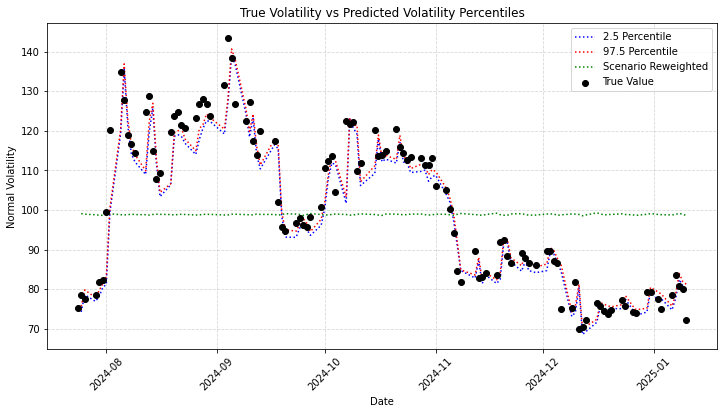

In [95]:
# Plot
plt.figure(figsize=(12, 6))
plt.plot(percentile_df.index, percentile_df["2.5 percentile"], linestyle="dotted", color="blue", label="2.5 Percentile")
plt.plot(percentile_df.index, percentile_df["97.5 percentile"], linestyle="dotted", color="red", label="97.5 Percentile")
plt.plot(percentile_df.index, percentile_df["reweighted"], linestyle="dotted", color="green", label="Scenario Reweighted")
plt.scatter(percentile_df.index, percentile_df["true"], color="black", label="True Value", zorder=3)

# Labels and Legend
plt.xlabel("Date")
plt.ylabel("Normal Volatility")
plt.title("True Volatility vs Predicted Volatility Percentiles")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.5)

# Show plot
plt.show()

In [ ]:
# combine surfaces to turn into dataframe
cat_surfaces = torch.cat(surfaces, dim=0)

# get dates from test set
test_dates = dates_t[-n_test:]
test_dates.name = 'Date'

In [ ]:
df_raw = pd.read_excel(SURFACE_PATH, header=None)
multi_index = pd.MultiIndex.from_arrays([df_raw.iloc[0], df_raw.iloc[1], df_raw.iloc[2]])
multi_index.names = multi_index[0]
multi_index = multi_index[1:]

In [63]:
df = pd.read_csv('outputs/generated_surfaces.csv', header=[0,1,2], index_col=0)

In [64]:
df

TERM (TENOR)                       1M                                          \
MATRUITY (EXPIRY)                  1Y                  2Y                  3Y   
Ticker            USSNAA1 ICPL Curncy USSNAA2 ICPL Curncy USSNAA3 ICPL Curncy   
Date                                                                            
2024-09-25                  96.744225          104.914390          103.024270   
2024-09-26                  96.587180          105.045820          102.637825   
2024-09-27                  98.785260          107.095410          104.696620   
2024-09-30                 100.624870          109.379380          107.152860   
2024-10-01                 109.679220          118.408740          115.970100   
...                               ...                 ...                 ...   
2025-01-06                  80.499550           99.558136          100.658550   
2025-01-07                  85.354324          104.317410          105.458140   
2025-01-08                  82.861755          102.019775          102.771140   
2025-01-09                  81.907400          101.916550          102.127340   
2025-01-10                  74.511200           97.917720           98.572230   

TERM (TENOR)                                                                   \
MATRUITY (EXPIRY)                  4Y                  5Y                  6Y   
Ticker            USSNAA4 ICPL Curncy USSNAA5 ICPL Curncy USSNAA6 ICPL Curncy   
Date                                                                            
2024-09-25                 101.999240           99.099655           96.520050   
2024-09-26                 101.183520           98.319460           95.556350   
2024-09-27                 103.189510          100.166140           97.773575   
2024-09-30                 105.662155          102.729210           99.958560   
2024-10-01                 114.695620          112.105400          108.995140   
...                               ...                 ...                 ...   
2025-01-06                 102.227620          104.330960          102.912830   
2025-01-07                 106.571760          108.826560          107.179650   
2025-01-08                 103.529274          104.922510          103.865630   
2025-01-09                 102.899790          104.174760          103.096130   
2025-01-10                 100.231520          102.032270          101.153520   

TERM (TENOR)                                                                   \
MATRUITY (EXPIRY)                  7Y                  8Y                  9Y   
Ticker            USSNAA7 ICPL Curncy USSNAA8 ICPL Curncy USSNAA9 ICPL Curncy   
Date                                                                            
2024-09-25                  93.556160           92.669464            91.59214   
2024-09-26                  93.130936           91.561980            89.70598   
2024-09-27                  95.066900           93.477356            91.88346   
2024-09-30                  97.409270           95.957060            94.29413   
2024-10-01                 105.991180          104.001625           102.46541   
...                               ...                 ...                 ...   
2025-01-06                 101.601845          100.877030           100.02701   
2025-01-07                 106.340850          105.080990           104.09947   
2025-01-08                 102.650980          102.768080           101.80015   
2025-01-09                 102.034870          102.095840           100.85176   
2025-01-10                 100.279020           99.913410            99.40048   

TERM (TENOR)                       3M  ...                  20Y  \
MATRUITY (EXPIRY)                  1Y  ...                   9Y   
Ticker            USSNAC1 ICPL Curncy  ... USSNA209 ICPL Curncy   
Date                                   ...                        
2024-09-25                 111.736786  ...            69.018870   
2024-09-26       

In [154]:
generated_surfaces = pd.DataFrame(cat_surfaces, columns = multi_index, index = test_dates)

In [156]:
generated_surfaces.to_csv('outputs/generated_surfaces.csv')

In [126]:
generated_surfaces = pd.read_csv('outputs/generated_surfaces.csv', header=[0,1,2], index_col=0)

In [110]:
df

TERM (TENOR)                       1M                                          \
MATRUITY (EXPIRY)                  1Y                  2Y                  3Y   
Ticker            USSNAA1 ICPL Curncy USSNAA2 ICPL Curncy USSNAA3 ICPL Curncy   
Date                                                                            
2024-09-25                    96.7442            104.9144            103.0243   
2024-09-26                    96.5872            105.0458            102.6378   
2024-09-27                    98.7853            107.0954            104.6966   
2024-09-30                   100.6249            109.3794            107.1529   
2024-10-01                   109.6792            118.4087            115.9701   
...                               ...                 ...                 ...   
2025-01-06                    80.4995             99.5581            100.6586   
2025-01-07                    85.3543            104.3174            105.4581   
2025-01-08                    82.8618            102.0198            102.7711   
2025-01-09                    81.9074            101.9166            102.1273   
2025-01-10                    74.5112             97.9177             98.5722   

TERM (TENOR)                                                                   \
MATRUITY (EXPIRY)                  4Y                  5Y                  6Y   
Ticker            USSNAA4 ICPL Curncy USSNAA5 ICPL Curncy USSNAA6 ICPL Curncy   
Date                                                                            
2024-09-25                   101.9992             99.0997             96.5200   
2024-09-26                   101.1835             98.3195             95.5563   
2024-09-27                   103.1895            100.1661             97.7736   
2024-09-30                   105.6622            102.7292             99.9586   
2024-10-01                   114.6956            112.1054            108.9951   
...                               ...                 ...                 ...   
2025-01-06                   102.2276            104.3310            102.9128   
2025-01-07                   106.5718            108.8266            107.1796   
2025-01-08                   103.5293            104.9225            103.8656   
2025-01-09                   102.8998            104.1748            103.0961   
2025-01-10                   100.2315            102.0323            101.1535   

TERM (TENOR)                                                                   \
MATRUITY (EXPIRY)                  7Y                  8Y                  9Y   
Ticker            USSNAA7 ICPL Curncy USSNAA8 ICPL Curncy USSNAA9 ICPL Curncy   
Date                                                                            
2024-09-25                    93.5562             92.6695             91.5921   
2024-09-26                    93.1309             91.5620             89.7060   
2024-09-27                    95.0669             93.4774             91.8835   
2024-09-30                    97.4093             95.9571             94.2941   
2024-10-01                   105.9912            104.0016            102.4654   
...                               ...                 ...                 ...   
2025-01-06                   101.6018            100.8770            100.0270   
2025-01-07                   106.3409            105.0810            104.0995   
2025-01-08                   102.6510            102.7681            101.8002   
2025-01-09                   102.0349            102.0958            100.8518   
2025-01-10                   100.2790             99.9134             99.4005   

TERM (TENOR)                       3M  ...                  20Y  \
MATRUITY (EXPIRY)                  1Y  ...                   9Y   
Ticker            USSNAC1 ICPL Curncy  ... USSNA209 ICPL Curncy   
Date                                   ...                        
2024-09-25                   111.7368  ...              69.0189   
2024-09-26       

In [73]:
sampledate = datetime(2024, 9, 25, 0, 0, 0)

In [75]:
next_day = datetime(2024, 9, 26, 0, 0, 0)

In [166]:
sampledate

datetime.datetime(2024, 9, 25, 0, 0)

In [ ]:
def scatter_swaption_surface(date, filename = "swaption_atm_vol_full.xlsx"):
    df = Inputs.volatility_data(date, filename)
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    x = df['Tenor']
    y = df['Maturity']
    z = df['Values']
    ax.scatter(x, y, z, c=z, cmap='viridis', marker='o')
    ax.set_xlabel('Tenor')
    ax.set_ylabel('Maturity')
    ax.set_zlabel('Implied Volatility')

    ax.set_title(f'Swaption Volatility Surface Forecast for {date + pd.DateOffset(1)}')
    
    plt.show()

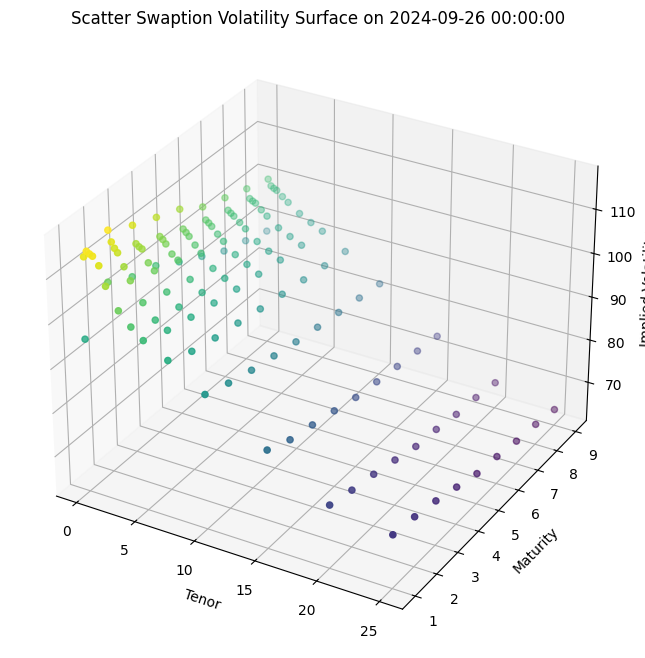

In [76]:
Inputs.scatter_swaption_surface(date=next_day, filename='data/swaption_atm_vol_no30y.xlsx')

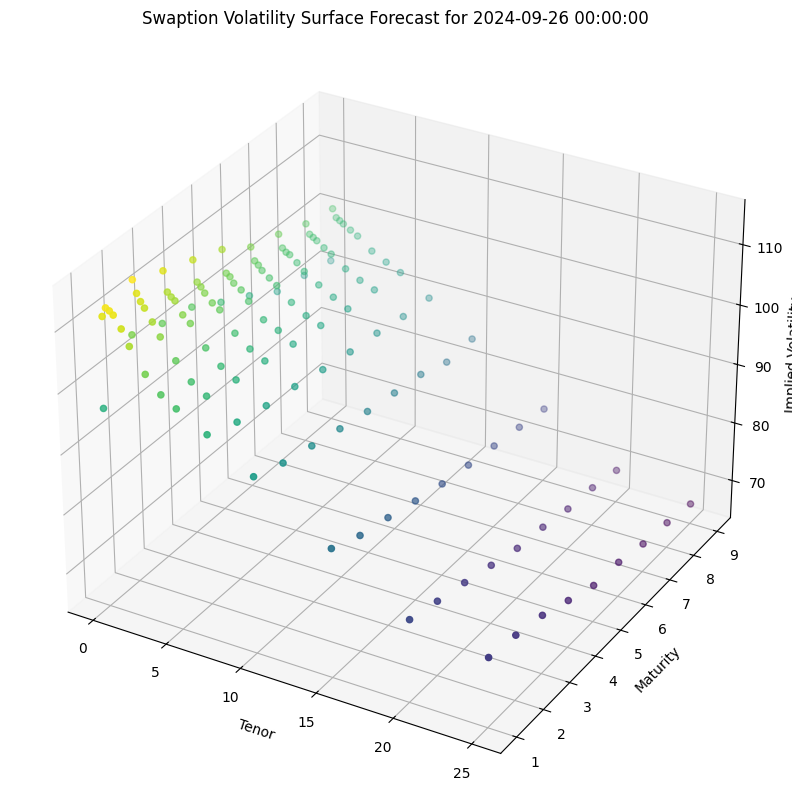

In [87]:
scatter_swaption_surface(date=sampledate, filename='outputs/generated_surfaces.xlsx')

In [142]:
forecast_vol_grid = Inputs.tabular_volatility_form(date=sampledate, filename='outputs/generated_surfaces.xlsx')
actual_vol_grid = Inputs.tabular_volatility_form(date=next_day, filename='data/swaption_atm_vol_no30y.xlsx')

In [144]:
import Evaluation as Eval

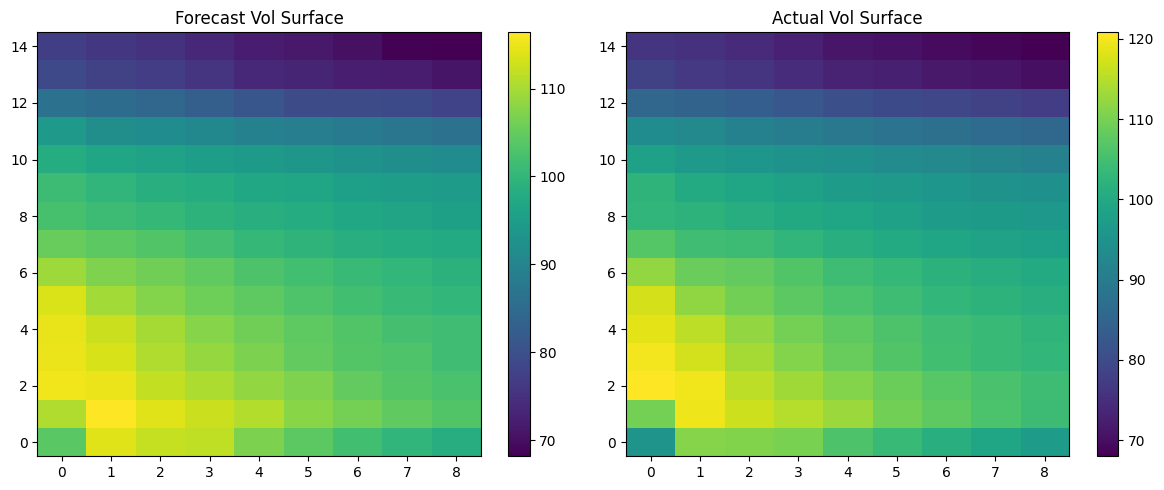

In [171]:
Eval.plot_forecast_vs_actual_vol_surface(
    gen, condition_test, true_test,
    noise_dim, device, 
    forecast_vol_idx=1, true_vol_idx=1,
    sample_idx=7
)

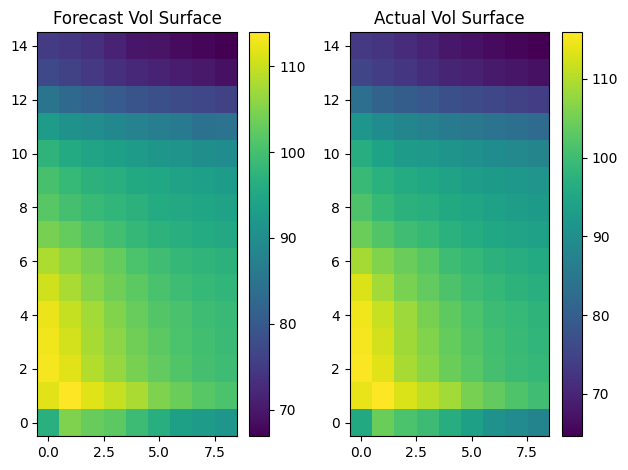

In [143]:
plt.subplot(1, 2, 1)
plt.imshow(forecast_vol_grid, aspect='auto', origin='lower', cmap='viridis')
plt.title("Forecast Vol Surface")
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(actual_vol_grid, aspect='auto', origin='lower', cmap='viridis')
plt.title("Actual Vol Surface")
plt.colorbar()

plt.tight_layout()
plt.show()

In [129]:
generated_surfaces = pd.read_excel('outputs/generated_surfaces.xlsx', header=[0,1,2], index_col=0)
df = pd.read_excel(SURFACE_PATH, header=[0,1,2], index_col=0).sort_index()

In [131]:
MAE = (generated_surfaces.shift(1) - df).dropna().abs().sum(axis=1) / df.shape[1]
MSE = ((generated_surfaces.shift(1) - df).dropna()**2).sum(axis=1) / df.shape[1]
RMSE = MSE**0.5

In [132]:
ERRORS = pd.DataFrame({'MAE': MAE, 'MSE': MSE, 'RMSE': RMSE})

In [133]:
dli.calc_univariate_statistics(ERRORS)

,Mean,Standard Deviation,Min,25th Percentile,Median,75th Percentile,Max,Skewness,Excess Kurtosis
MAE,1.4124,0.5012,0.6957,1.0289,1.2574,1.6608,2.7369,0.7851,-0.2192
MSE,4.1314,4.7797,0.6979,1.7762,2.6564,4.1587,34.6828,4.1372,23.2713
RMSE,1.8499,0.8480,0.8354,1.3327,1.6298,2.0393,5.8892,2.0534,6.3444


In [134]:
naive_df = df.iloc[(-n_test-1):]

In [135]:
naive_mae = (naive_df - naive_df.shift(1)).dropna().abs().sum(axis=1) / naive_df.shape[1]
naive_mse = ((naive_df - naive_df.shift(1)).dropna()**2).sum(axis=1) / naive_df.shape[1]
naive_rmse = naive_mse**0.5

In [137]:
naive_errors = pd.DataFrame({'MAE': naive_mae, 'MSE': naive_mse, 'RMSE': naive_rmse})

In [138]:
dli.calc_univariate_statistics(naive_errors)

,Mean,Standard Deviation,Min,25th Percentile,Median,75th Percentile,Max,Skewness,Excess Kurtosis
MAE,0.8535,0.5304,0.1815,0.4733,0.7163,0.9985,2.5578,1.3880,1.5854
MSE,2.5794,4.7183,0.0504,0.4622,1.0279,2.3766,34.2342,4.7622,28.6122
RMSE,1.3018,0.9471,0.2246,0.6799,1.0138,1.5416,5.8510,2.2179,6.9121


In [89]:
n_test = true_test.shape[0]
underlying_dim = true_test.shape[1]
B = 50000

# collecting test surfaces from the generator

time_series_returns = []

with torch.no_grad():
    for l in tqdm(range(B)):
        #sample noise
        noise = torch.randn((n_test, underlying_dim, noise_dim), device=device,dtype=torch.float)
        #sample from the generator
        fake = gen(noise,condition_test[:,:,:])

        #simulated implied vol surfaces as vectors
        fake_returns = fake[:,:,:1]

        time_series_returns.append(fake_returns[:, 0, 0])

100%|██████████| 50000/50000 [03:45<00:00, 221.51it/s]


In [94]:
true_test[:, 0, 0]

tensor([ 12.4740,  18.6228, -19.2024,  26.0820, -13.7592,  11.0880,  21.2436,
         66.6540,  23.5872,  -8.0136,  15.8004, -19.3284,  -0.8064,  -2.9736,
         -6.4260,   9.9792,  -6.2244,  27.9720,   3.5280,  11.3400,  -4.4100,
          9.6516,  13.9608, -12.6504,  25.4520,  -4.0824,  12.3228,  -9.5256,
          8.9712,  30.6684, -21.0420,  18.1692,  26.2836, -15.6996,  14.8680,
        -10.8612,  -5.7456,   1.4112,   7.8120,  10.7856,   8.1900, -28.1736,
          7.8120, -11.6424, -10.2060,   0.7056,   0.3528, -19.9836,   6.3000,
        -10.3824,   7.5600,   7.5096,   3.4776,  12.4236,  15.2460,   4.5108,
         -1.5876,  39.3624,  -9.9792,  -3.2004,   7.1316,  -3.6792,  -1.4364,
          3.1248, -22.8060,  -3.1752,   5.7204,  11.4408,   2.5452,   4.3092,
         -6.7284,  -5.4432,  38.1276])

In [96]:
Y1_M1_pred = pd.DataFrame(time_series_returns)

In [97]:
Y1_M1_pred = Y1_M1_pred.applymap(lambda x: x.item() if isinstance(x, torch.Tensor) else x)

In [98]:
Y1_M1_pred

,0,1,2,3,4,5,6,7,8,9,...,63,64,65,66,67,68,69,70,71,72
0,-3.9241,-8.2447,-20.6535,-42.7549,6.1939,26.5608,5.8634,-44.8665,0.2584,9.0210,...,-15.7101,24.2079,4.0255,-6.5885,-5.3411,-16.6528,9.9279,29.2070,7.2391,4.9562
1,-0.1131,-4.4392,-20.1543,-14.1100,26.2202,-29.4835,19.2247,-17.6722,-12.7103,-33.5069,...,5.7459,-6.1881,-6.9344,12.1246,-2.1264,14.7716,5.2483,-8.3919,19.5598,-5.3102
2,11.3696,2.7347,17.3798,24.3391,5.1577,-39.7837,12.8447,-8.6437,1.6092,17.5341,...,5.0026,-2.8037,10.3221,-1.5728,3.8337,-19.1661,12.0295,16.7478,-18.6419,-37.2168
3,23.8228,-29.5909,-12.8210,24.0462,-2.3858,-3.6466,1.2386,-37.4207,-6.5450,-33.3991,...,5.3083,-13.2898,16.9632,-10.3814,11.9094,15.7811,-3.9600,-18.1179,18.7439,11.8635
4,36.4455,-11.7283,2.4643,-1.7026,-7.3695,0.9791,23.4969,-15.3350,-14.5348,-4.2064,...,-1.7536,18.9588,-8.0490,21.6992,13.2140,3.4398,27.6937,30.3078,12.3454,16.2390
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,2.9941,-0.6634,7.3907,-17.7882,21.8172,-29.0327,-9.7355,17.5028,-20.7849,-10.8292,...,30.7680,-33.2003,14.3184,36.5103,17.5166,19.7901,16.2067,15.7042,-14.6043,31.2674
49996,-7.3901,-22.6419,10.3044,0.4517,17.3228,-10.1419,-10.0121,17.6449,-14.0481,-25.7237,...,3.6588,-22.5638,11.8570,-10.7174,6.6833,-10.1413,19.3395,23.7574,-3.3958,-4.2393
49997,33.9460,23.0156,-21.7673,15.7890,-13.3663,-8.8488,25.3328,0.0885,-6.2206,0.2637,...,5.9664,23.8419,-7.7914,-6.7501,-6.7615,-18.5246,12.9670,7.6956,8.4622,16.8256
49998,-16.9420,-2.4713,-21.7340,-3.7389,28.3438,-1.8393,20.2742,-21.5853,8.7381,-16.9162,...,11.6027,-9.1667,13.0689,-16.9484,-14.7100,25.3380,3.7686,23.1535,-0.3418,-21.2402


In [ ]:
Y1_M1_pred.quantile(0.025)

0     96.7044
1     96.4830
2     98.5551
3    100.5431
4    109.5532
       ...   
68    79.9204
69    84.7836
70    82.5437
71    81.4667
72    73.7007
Name: 0.025, Length: 73, dtype: float64

In [99]:
percentile_2_5 = Y1_M1_pred.quantile(0.025).shift(1)
percentile_97_5 = Y1_M1_pred.quantile(0.975).shift(1)

# Create a new DataFrame to store the timeseries of percentiles
percentile_df = pd.DataFrame({
    '2.5 percentile': percentile_2_5,
    '97.5 percentile': percentile_97_5
})

In [100]:
percentile_df.index = pd.to_datetime(dates_t[-n_test:])

In [101]:
true_returns = true_test[:, 0, 0]

In [102]:
percentile_df['true'] = true_returns

In [104]:
percentile_df

,2.5 percentile,97.5 percentile,true
Ticker,,,
2024-09-25,NaN,NaN,12.4740
2024-09-26,-31.3531,29.2184,18.6228
2024-09-27,-30.8828,32.9981,-19.2024
2024-09-30,-34.5483,27.1285,26.0820
2024-10-01,-33.0693,25.6726,-13.7592
...,...,...,...
2025-01-06,-29.5079,30.1524,2.5452
2025-01-07,-30.9434,28.4159,4.3092
2025-01-08,-31.1546,27.4545,-6.7284


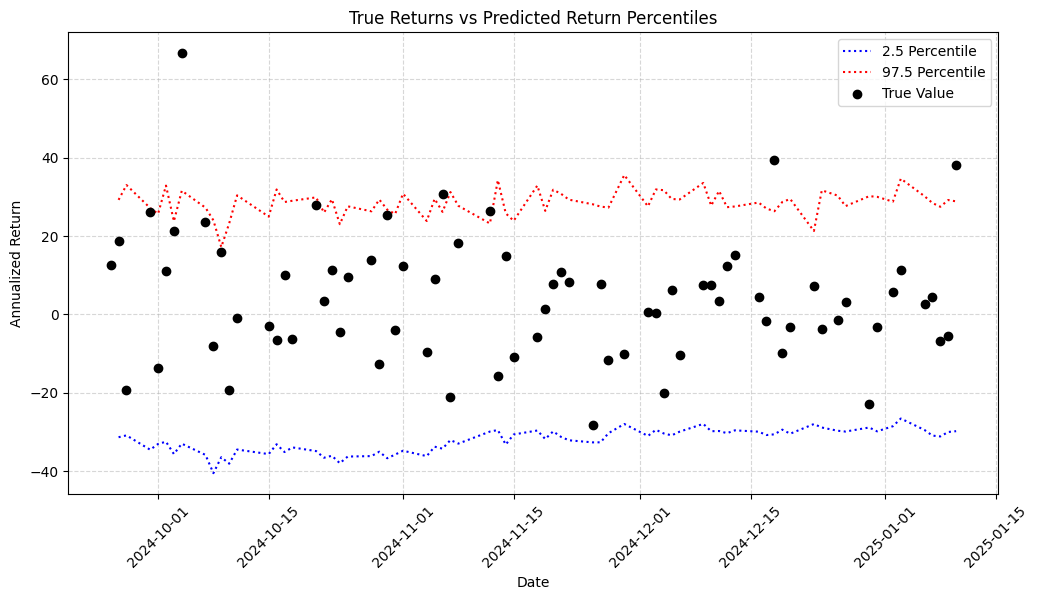

In [106]:
# Plot
plt.figure(figsize=(12, 6))
plt.plot(percentile_df.index, percentile_df["2.5 percentile"], linestyle="dotted", color="blue", label="2.5 Percentile")
plt.plot(percentile_df.index, percentile_df["97.5 percentile"], linestyle="dotted", color="red", label="97.5 Percentile")
plt.scatter(percentile_df.index, percentile_df["true"], color="black", label="True Value", zorder=3)

# Labels and Legend
plt.xlabel("Date")
plt.ylabel("Annualized Return")
plt.title("True Returns vs Predicted Return Percentiles")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.5)

# Show plot
plt.show()